In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import glob

mpl.rcParams['figure.dpi'] = 300


def loadFile(name):
    data=pd.read_csv(name,sep="\t")
    data["H"]=np.round(data["B_extx (T)"]*10000/(np.sqrt(2)/2))
    data["m_full"]=(data["m_fullx (A/m)"]+data["m_fully (A/m)"])/np.sqrt(2)
    data["m"]=data["m_full"]/np.max(np.abs(data["m_full"]))

    try: 
        data["hIsland_my"]=data["m_full.region1y (A/m)"]/np.max(np.sqrt(data["m_full.region1y (A/m)"]**2+data["m_full.region1x (A/m)"]**2))
    except Exception:
        pass
    

    data=data.drop(columns=["# t (s)",\
    "mz ()","mx ()", "my ()",\
    "B_extx (T)", "B_exty (T)","B_extz (T)",\
    "m_fullz (A/m)","m_fullx (A/m)","m_fully (A/m)",\
    "m_full.region1x (A/m)","m_full.region1y (A/m)","m_full.region1z (A/m)",\
    "m_full.region2x (A/m)","m_full.region2y (A/m)","m_full.region2z (A/m)"])

    try:
        data.attrs["Hc"]=np.average(np.abs(data[np.sign(data["m"]).diff() != 0]["H"].iloc[1:]))
        data.attrs["Br"]=np.average(np.abs(data[np.sign(data["H"]).diff() != 0]["m"].iloc[1:]))
    except Exception:
        pass


    return data

def decodeAttributes(string):
    dict={}
    desc=string.split(";")
    for attribute in desc:
        dict[attribute[0]] = float(attribute[1:])
    return dict["p"], dict["a"], dict["l"], dict["s"]

def getPossibleVals(data):
    pointinessVals=[]
    spacingVals=[]
    lengthVals=[]
    for i in data:
        if round(i.attrs["pointiness"],5) not in pointinessVals: pointinessVals.append(round(i.attrs["pointiness"],5))
        if i.attrs["length"] not in lengthVals: lengthVals.append(i.attrs["length"])
        if i.attrs["spacing"] not in spacingVals: spacingVals.append(i.attrs["spacing"])

    pointinessVals.sort()
    spacingVals.sort()
    lengthVals.sort()

    return pointinessVals, spacingVals, lengthVals

def getRuns(spacing,pointiness,length):
    minDist=None
    bestRun=None

    runs=[]
    for run in data:
        dist=abs(run.attrs["spacing"]-spacing)*1e9+abs(run.attrs["pointiness"]-pointiness)*100+abs(run.attrs["length"]-length)*1e9
        if dist<0.01:
            runs.append(run)
    
    return runs



data=[]
filePrefix="data/"
for name in glob.glob(filePrefix+"*.out"):
    try:
        thisData=loadFile(name+"/table.txt")
    except Exception:
        print(f"Could not load {name}")
        continue

    desc=name[len(filePrefix):-len(".out")]
    pointiness, spacing, length, runNum = decodeAttributes(desc)

    thisData.attrs["pointiness"]=pointiness
    thisData.attrs["spacing"]=spacing
    thisData.attrs["length"]=length
    thisData.attrs["runNum"]=runNum

    data.append(thisData)

pointinessVals, spacingVals, lengthVals = getPossibleVals(data)
print(getPossibleVals(data))

def indexOfSame(arr):
    if arr[0]==arr[1] or arr[0]==arr[2]:
        return 0
    if arr[1] == arr[2]:
        return 1

def selectRunIndex(runs):
    Brs = np.array([run.attrs["Br"] for run in runs])
    Hcs = np.array([run.attrs["Hc"] for run in runs])
    Mys = np.array([min(run["hIsland_my"]) for run in runs])

    allAgree=True
    selectedI=None
    for i in [0,1,2]:
        for j in [0,1,2]:
            if i==j: continue

            if(abs(Brs[i]-Brs[j])<0.001 and abs(Hcs[i]-Hcs[j])<1 and abs(Mys[i]-Mys[j]) < 0.001):
                selectedI=i
            else:
                allAgree=False
    
    return allAgree, selectedI



def removeDuplicateRuns(data):
    newData=[]
    numFixes=0
    totalRunCount=0
    unfixable=0
    insufficientTrials=0

    for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)<3:
                    if len(runs)>0:
                        print(pointiness,spacing,length)
                        insufficientTrials+=1
                    continue
                if len(runs)>3:
                    runs=runs[0:3]

                    
                totalRunCount+=1


                Brs = np.array([run.attrs["Br"] for run in runs])
                Hcs = np.array([run.attrs["Hc"] for run in runs])
                Mys = np.array([min(run["hIsland_my"]) for run in runs])

                
                
                allAgree, i = selectRunIndex(runs)

                if not allAgree: numFixes += 1

                if i is None:
                    print(f"Inconsistent data for {pointiness}, {spacing}, {length}")
                    unfixable+=1
                    continue

                newData.append(runs[i])

    print(f"Fixed data for {numFixes}/{totalRunCount} runs. {unfixable} runs unfixable, {insufficientTrials} not enough data")
    return newData

data = removeDuplicateRuns(data)


                



for pointiness in pointinessVals:
        for spacing in spacingVals:
            for length in lengthVals:
                runs=getRuns(spacing,pointiness,length)
                if len(runs)>1:
                    print(pointiness,spacing,length)
                    raise Exception()

                    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Library/Frameworks/Python.framewor

Could not load data/p0.out
([0.0, 0.1, 0.2, 0.26667, 0.2963, 0.3, 0.34783, 0.4, 0.44444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06], [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07])
Inconsistent data for 0.1, 3.0000000000000004e-07, 1.8000000000000002e-07
Inconsistent data for 0.1, 3.0000000000000004e-07, 2.0000000000000002e-07
Inconsistent data for 0.1, 3.4000000000000003e-07, 2.3000000000000002e-07
Inconsistent data for 0.1, 3.8e-07, 2.7e-07
Inconsistent data for 0.2, 3.2e-07, 2.3000000000000002e-07
Inconsistent data for 0.6, 4.0000000000000003e-07, 2.0000000000000002e-07
Fixed data for 46/505 runs. 6 runs unfixable, 0 not enough data


In [2]:
print(pointinessVals,"\n",spacingVals,"\n",lengthVals)

[0.0, 0.1, 0.2, 0.26667, 0.2963, 0.3, 0.34783, 0.4, 0.44444, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
 [2.8e-07, 3.0000000000000004e-07, 3.2e-07, 3.4000000000000003e-07, 3.6000000000000005e-07, 3.8e-07, 4.0000000000000003e-07, 4.2e-07, 4.4e-07, 5.12e-07, 1.024e-06] 
 [1.8000000000000002e-07, 2.0000000000000002e-07, 2.3000000000000002e-07, 2.7e-07, 3.0000000000000004e-07]


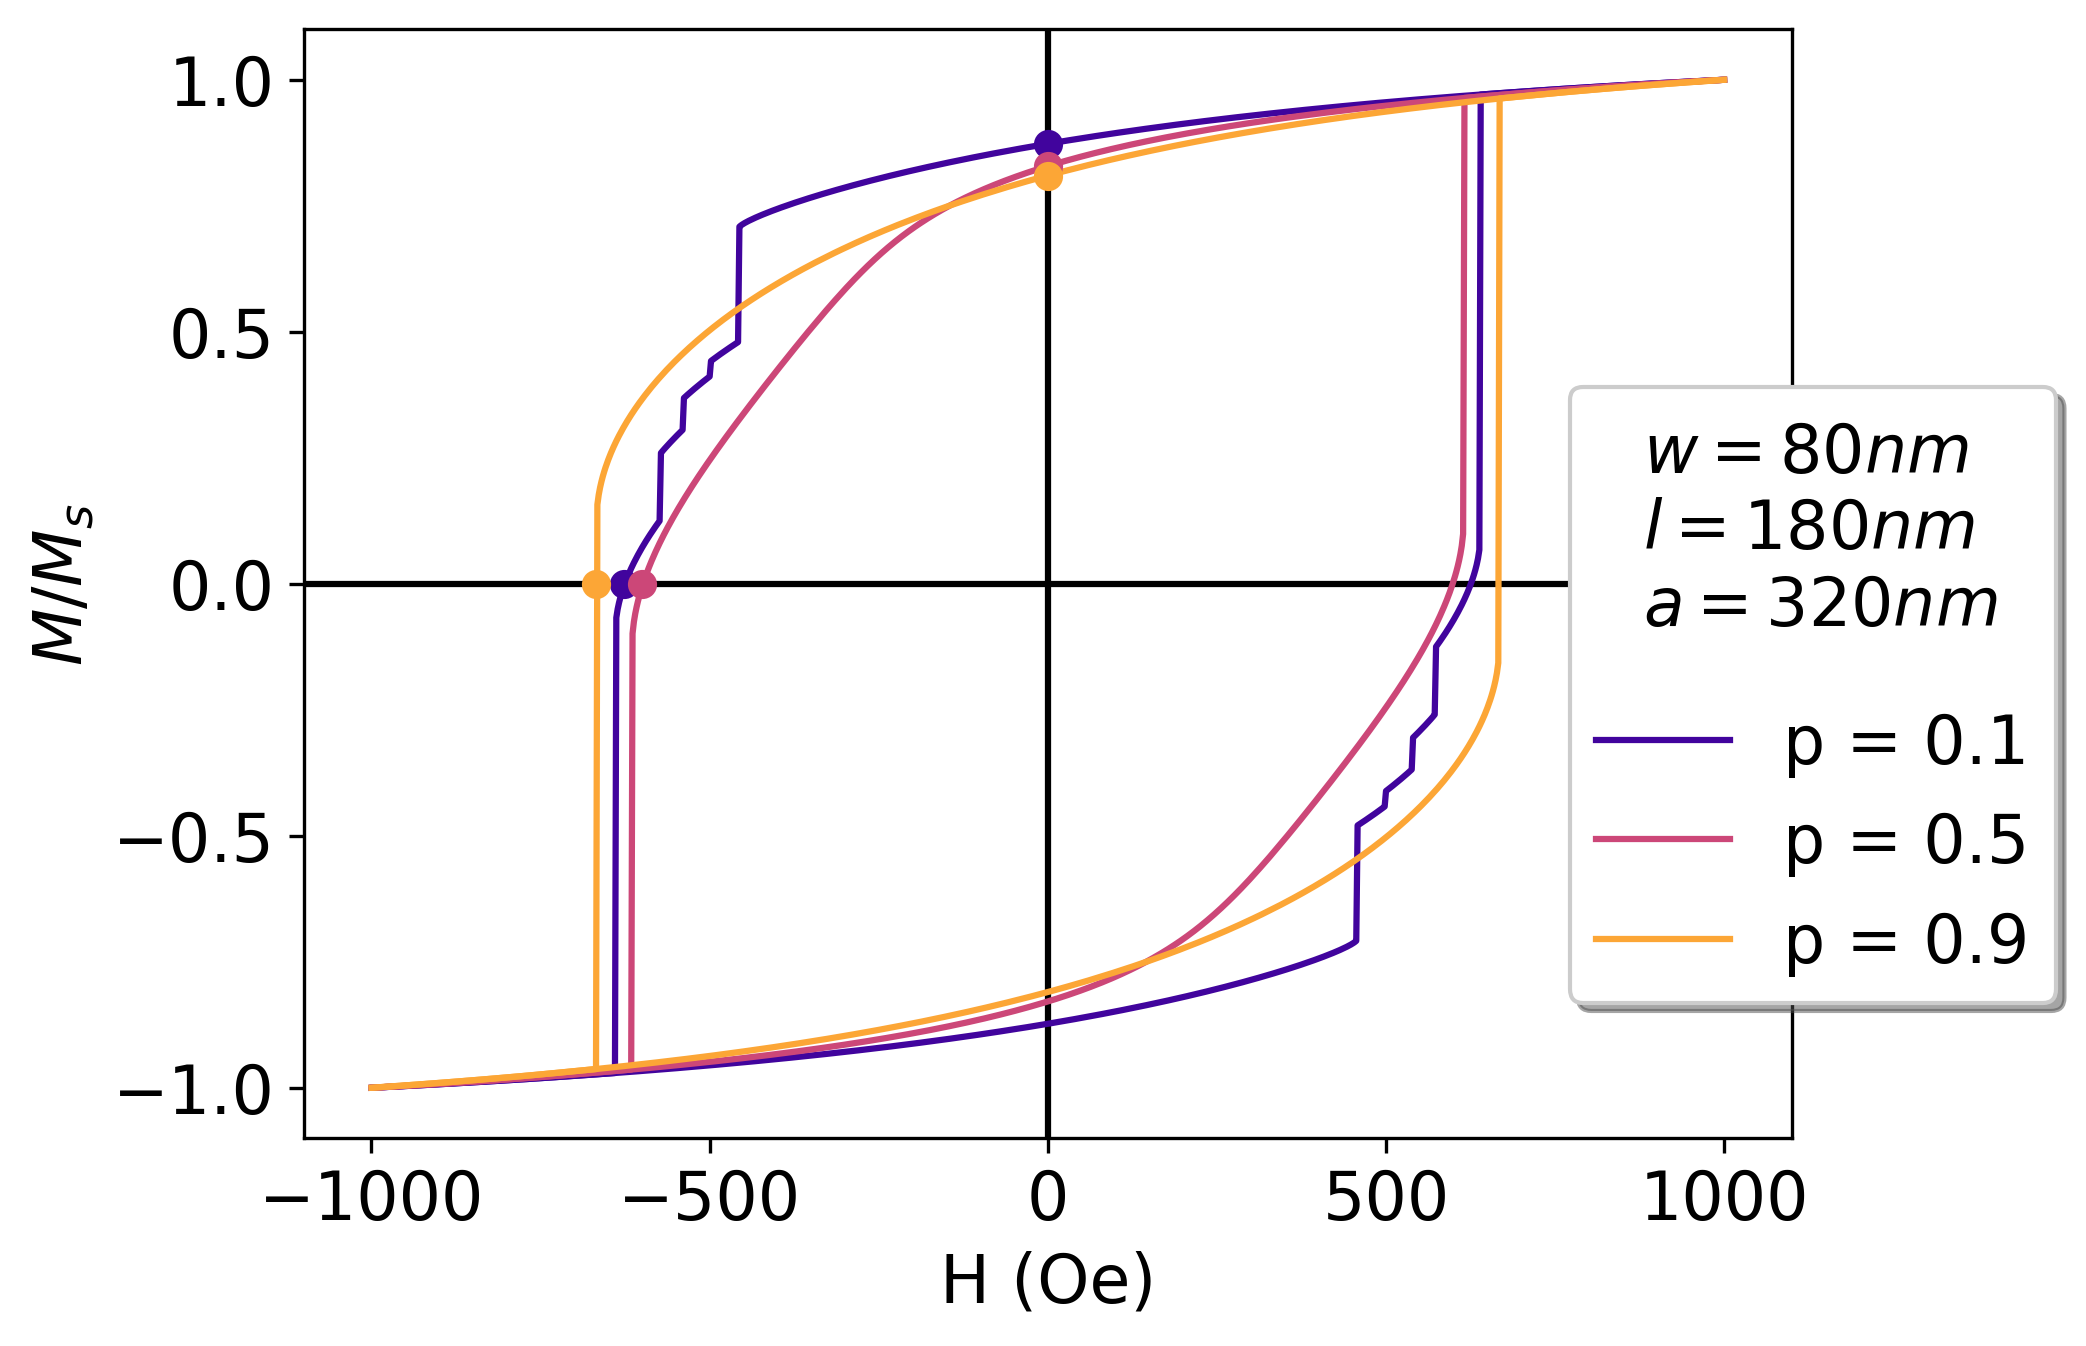

In [3]:
plt.rcParams.update({'font.size': 16})



#def getRuns(spacing,pointiness,length):
runLess=getRuns(3.2e-7,0.1,1.8e-7)[0]
run=getRuns(3.2e-7,0.5,1.8e-7)[0]

runMore=getRuns(3.2e-7,0.9,1.8e-7)[0]

runs=[runLess,run,runMore]
colors=plt.cm.plasma([0.1,0.5,0.8])

fig, ax = plt.subplots()

plt.axvline(0,color="k",ls="-")
plt.axhline(0,color="k",ls="-")
for i in range(len(runs)):
    run=runs[i]
    color=colors[i]
    plt.plot(run["H"],run["m"], label=f"p = {round(run.attrs['pointiness'],1)}",color=color)
    plt.plot(-run["H"],-run["m"],color=color)
    
    #plt.axvline(-run.attrs["Hc"],ls=":",color=color)
    #plt.axhline(run.attrs["Br"],ls="--",color=color)
    plt.scatter(0,run.attrs["Br"],color=color,zorder=10)
    plt.scatter(-run.attrs["Hc"],0,color=color,zorder=10)

    """plt.xlim(-50,50)
    plt.ylim(0.78,0.9)
    plt.axhline(run.attrs["Br"],ls="--",color=color)
    plt.scatter(0,run.attrs["Br"],color=color)
    plt.xticks([])"""

    """plt.xlim(-750,-500)
    plt.ylim(-0.2,0.2)
    plt.axvline(-run.attrs["Hc"],ls="--",color=color)"""

#line = mpl.lines.Line2D([0], [0], ls=":", label='$H_c$', color='k')
#line2 = mpl.lines.Line2D([0], [0], ls="--", label='$M_r$', color='k')
l = mpl.lines.Line2D([0],[0],color="w")
handles, labels = plt.gca().get_legend_handles_labels()
handles = [l,l,l]+handles
#handles.extend([line,line2])

plt.text(0.9, 0.45, '$w = 80nm$\n$l = 180nm$\n$a = 320nm$', horizontalalignment='left',
     verticalalignment='bottom',transform=ax.transAxes, fontsize=16, zorder=100)

plt.xlabel("H (Oe)")
plt.ylabel("$M/M_s$")
#plt.title("$H_c$ and $M_r$ for varying island shapes")
plt.legend(handles=handles,loc='center right', bbox_to_anchor=(1.2, 0.4),
          ncol=1, shadow=True)
plt.show()




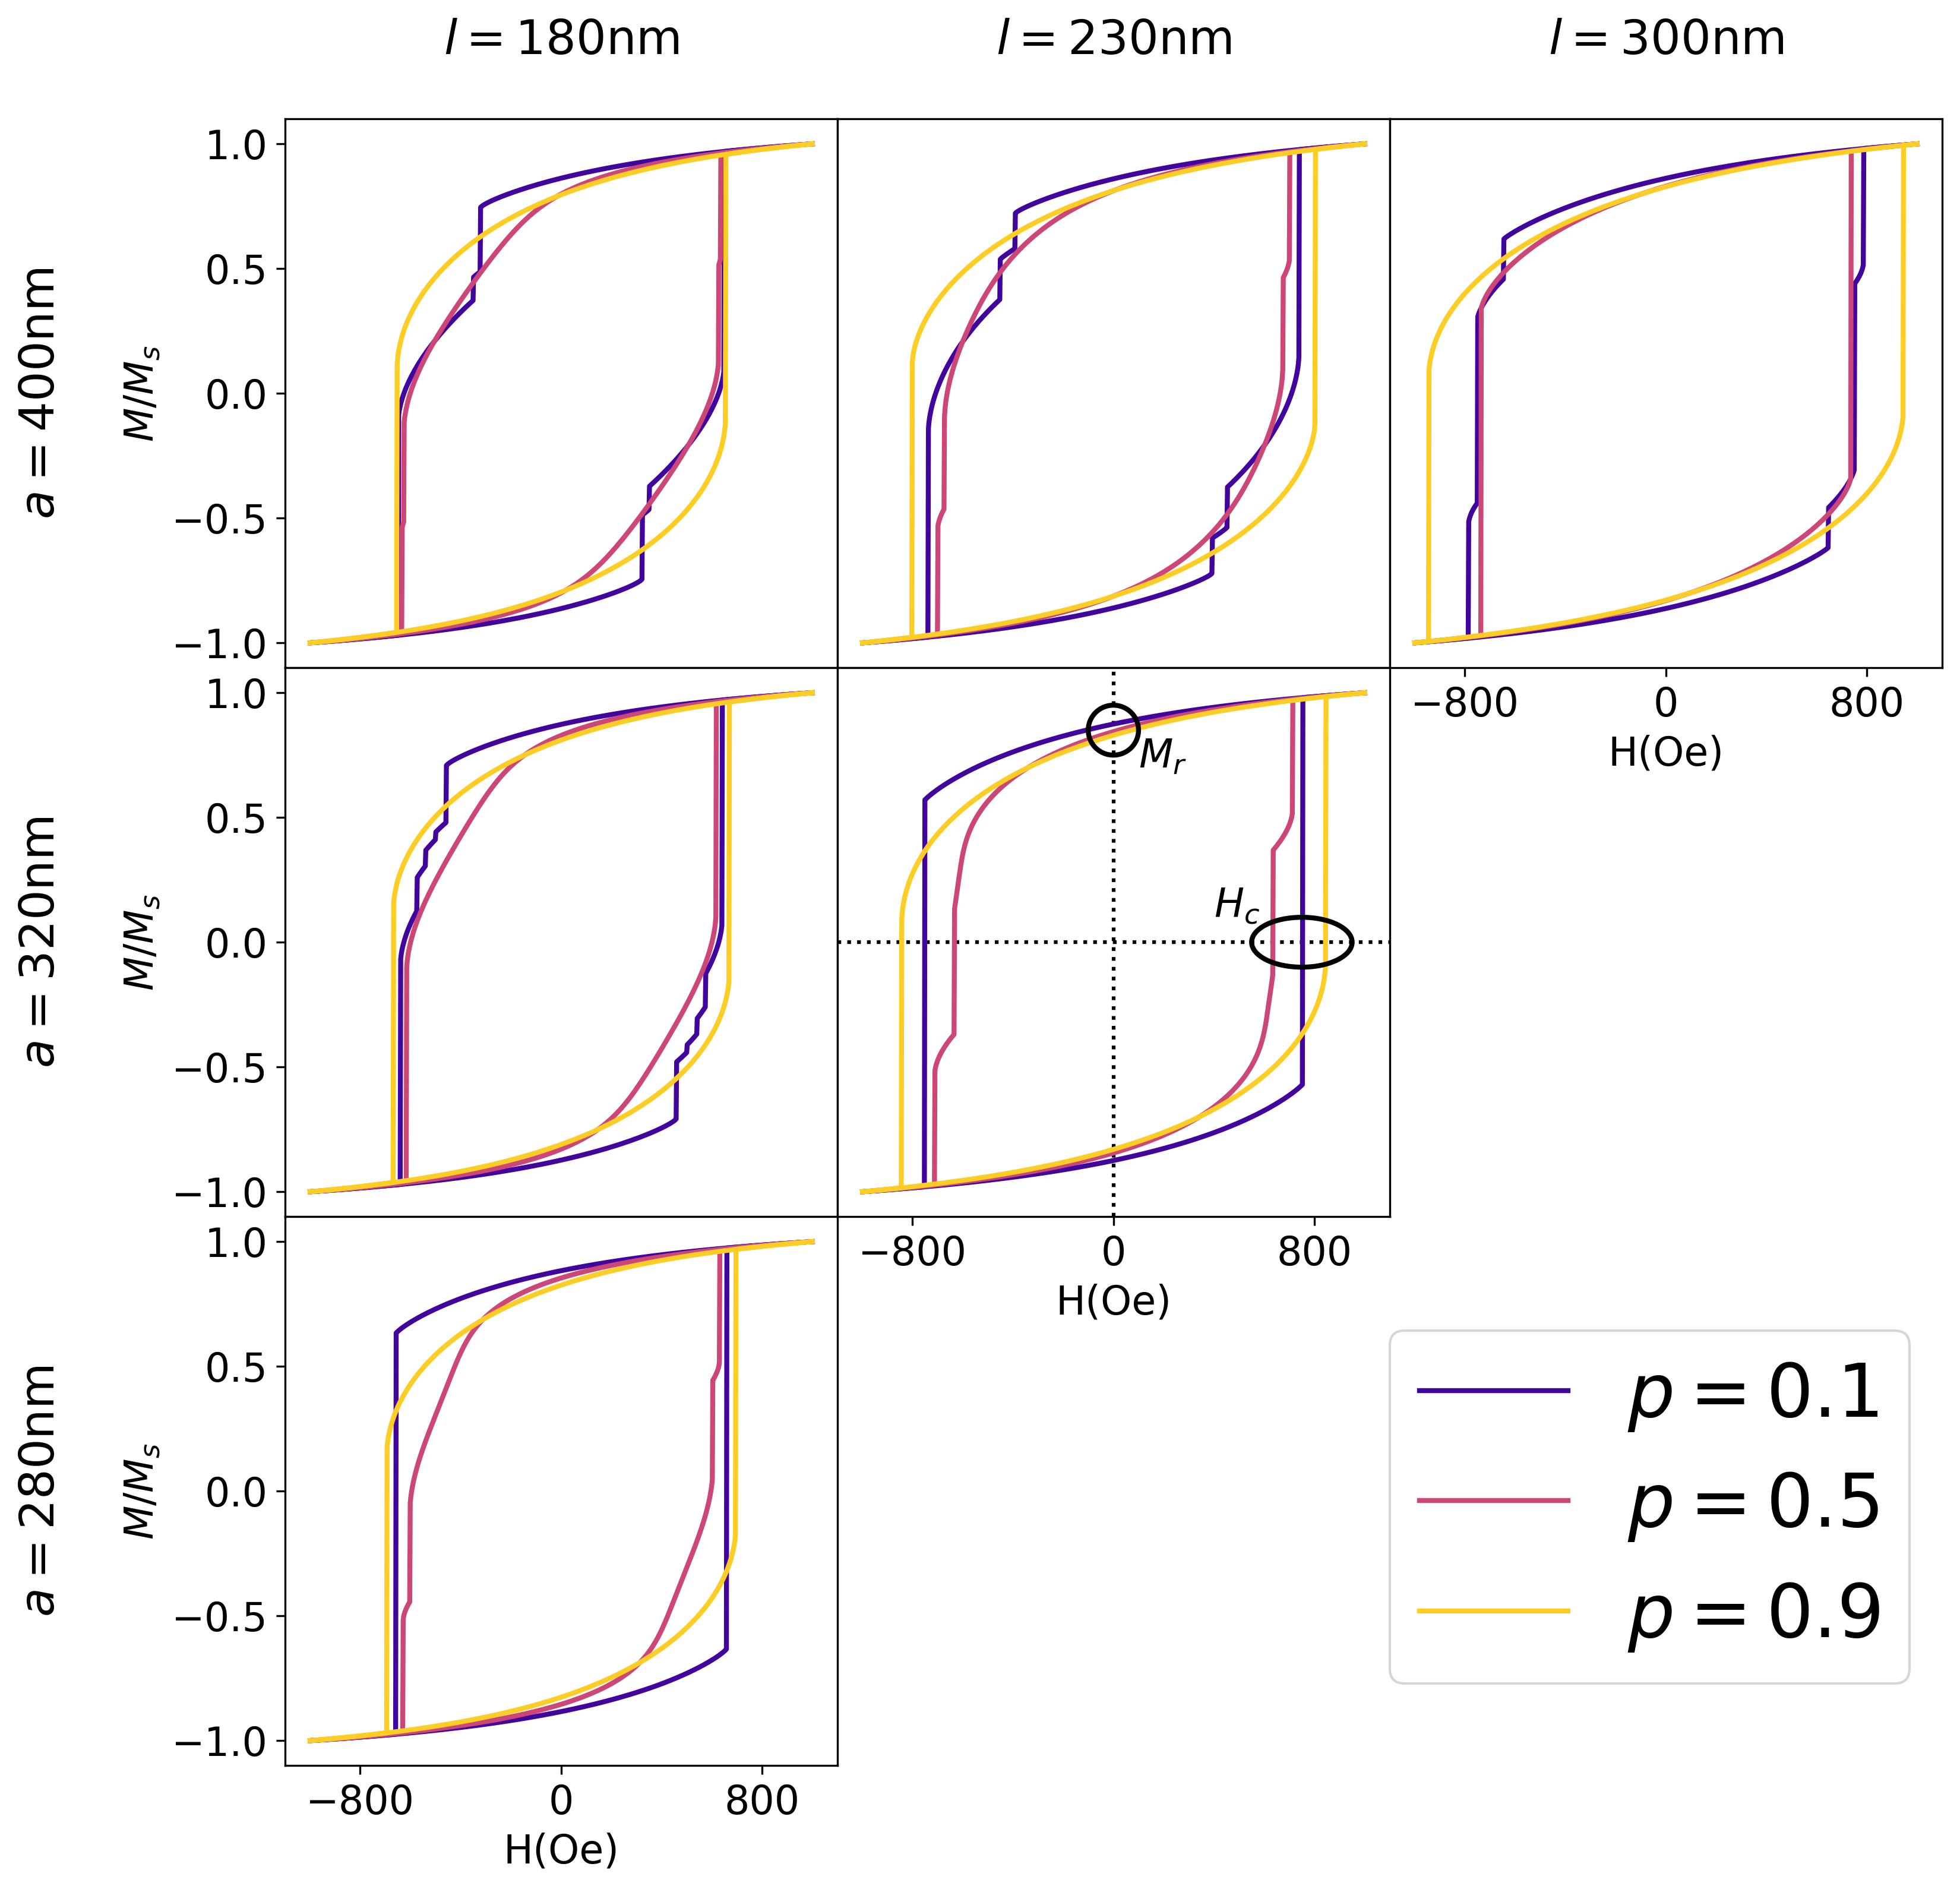

In [188]:
mpl.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(3,3)
fig.set_size_inches(12,12)
plt.subplots_adjust(wspace=0, hspace=0)

lengthVals =np.array([180,230,300])*1e-9
spacingVals = np.array([280,320,400])[::-1]*1e-9

pointinessVals=[0.1,0.5,0.9]


for i,(spacing,axRow) in enumerate(zip(spacingVals,axs)):
    for j,(length,ax) in enumerate(zip(lengthVals,axRow)):
        if i>(2-j):
            ax.remove()
            
            continue
        if j!=0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(f"{spacing}")
            ax.set_ylabel("$M/M_s$")
            #ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
            #    xycoords=ax.yaxis.label, textcoords='offset points',
            #    size='large', ha='right', va='center')
            ax.annotate(f"$a={round(spacing*1e9)}$nm",(-0.4,0.5),ha="right",va="center",size="large",xycoords="axes fraction",rotation=90)
        if i!=2-j: 
            ax.set_xticks([])
        else:
            ax.set_xticks([-800,0,800])
            ax.set_xlabel("H(Oe)")
        if i==0: ax.annotate(f"$l={round(length*1e9)}$nm",(0.5,1.1),ha="center",va="bottom",size="large",xycoords="axes fraction")

        if i==1 and j==1:
            ax.axvline(0,c="k",ls=":")
            ax.axhline(0,c="k",ls=":")
            ax.add_patch(mpl.patches.Ellipse((750,0),400,0.2,fill=False,linewidth=2,zorder=3))
            ax.add_patch(mpl.patches.Ellipse((0,0.85),200,0.2,fill=False,linewidth=2,zorder=3))
            ax.text(400,0.1,"$H_c$")
            ax.text(100,0.7,"$M_r$")

        

        for pointiness in pointinessVals:
            run=getRuns(spacing,pointiness,length)
            if len(run)==1:run=run[0]
            else: 
                print(pointiness,spacing,length)
                continue
            
            ax.plot(run["H"],run["m"],c=plt.cm.plasma(pointiness),label=f"$p={pointiness}$",lw=2)
            ax.plot(run["H"],-run["m"][::-1],c=plt.cm.plasma(pointiness),lw=2)
            
            #ax.scatter(0,run.attrs["Br"],marker="x",c=[plt.cm.plasma(pointiness)],zorder=3,s=100)
            #ax.scatter(run.attrs["Hc"],0,marker="3",c=[plt.cm.plasma(pointiness)],zorder=3,s=150)

#fig.tight_layout()
plt.legend(loc=(2,0.15),fontsize="30",)
plt.savefig("test.png",bbox_inches='tight')


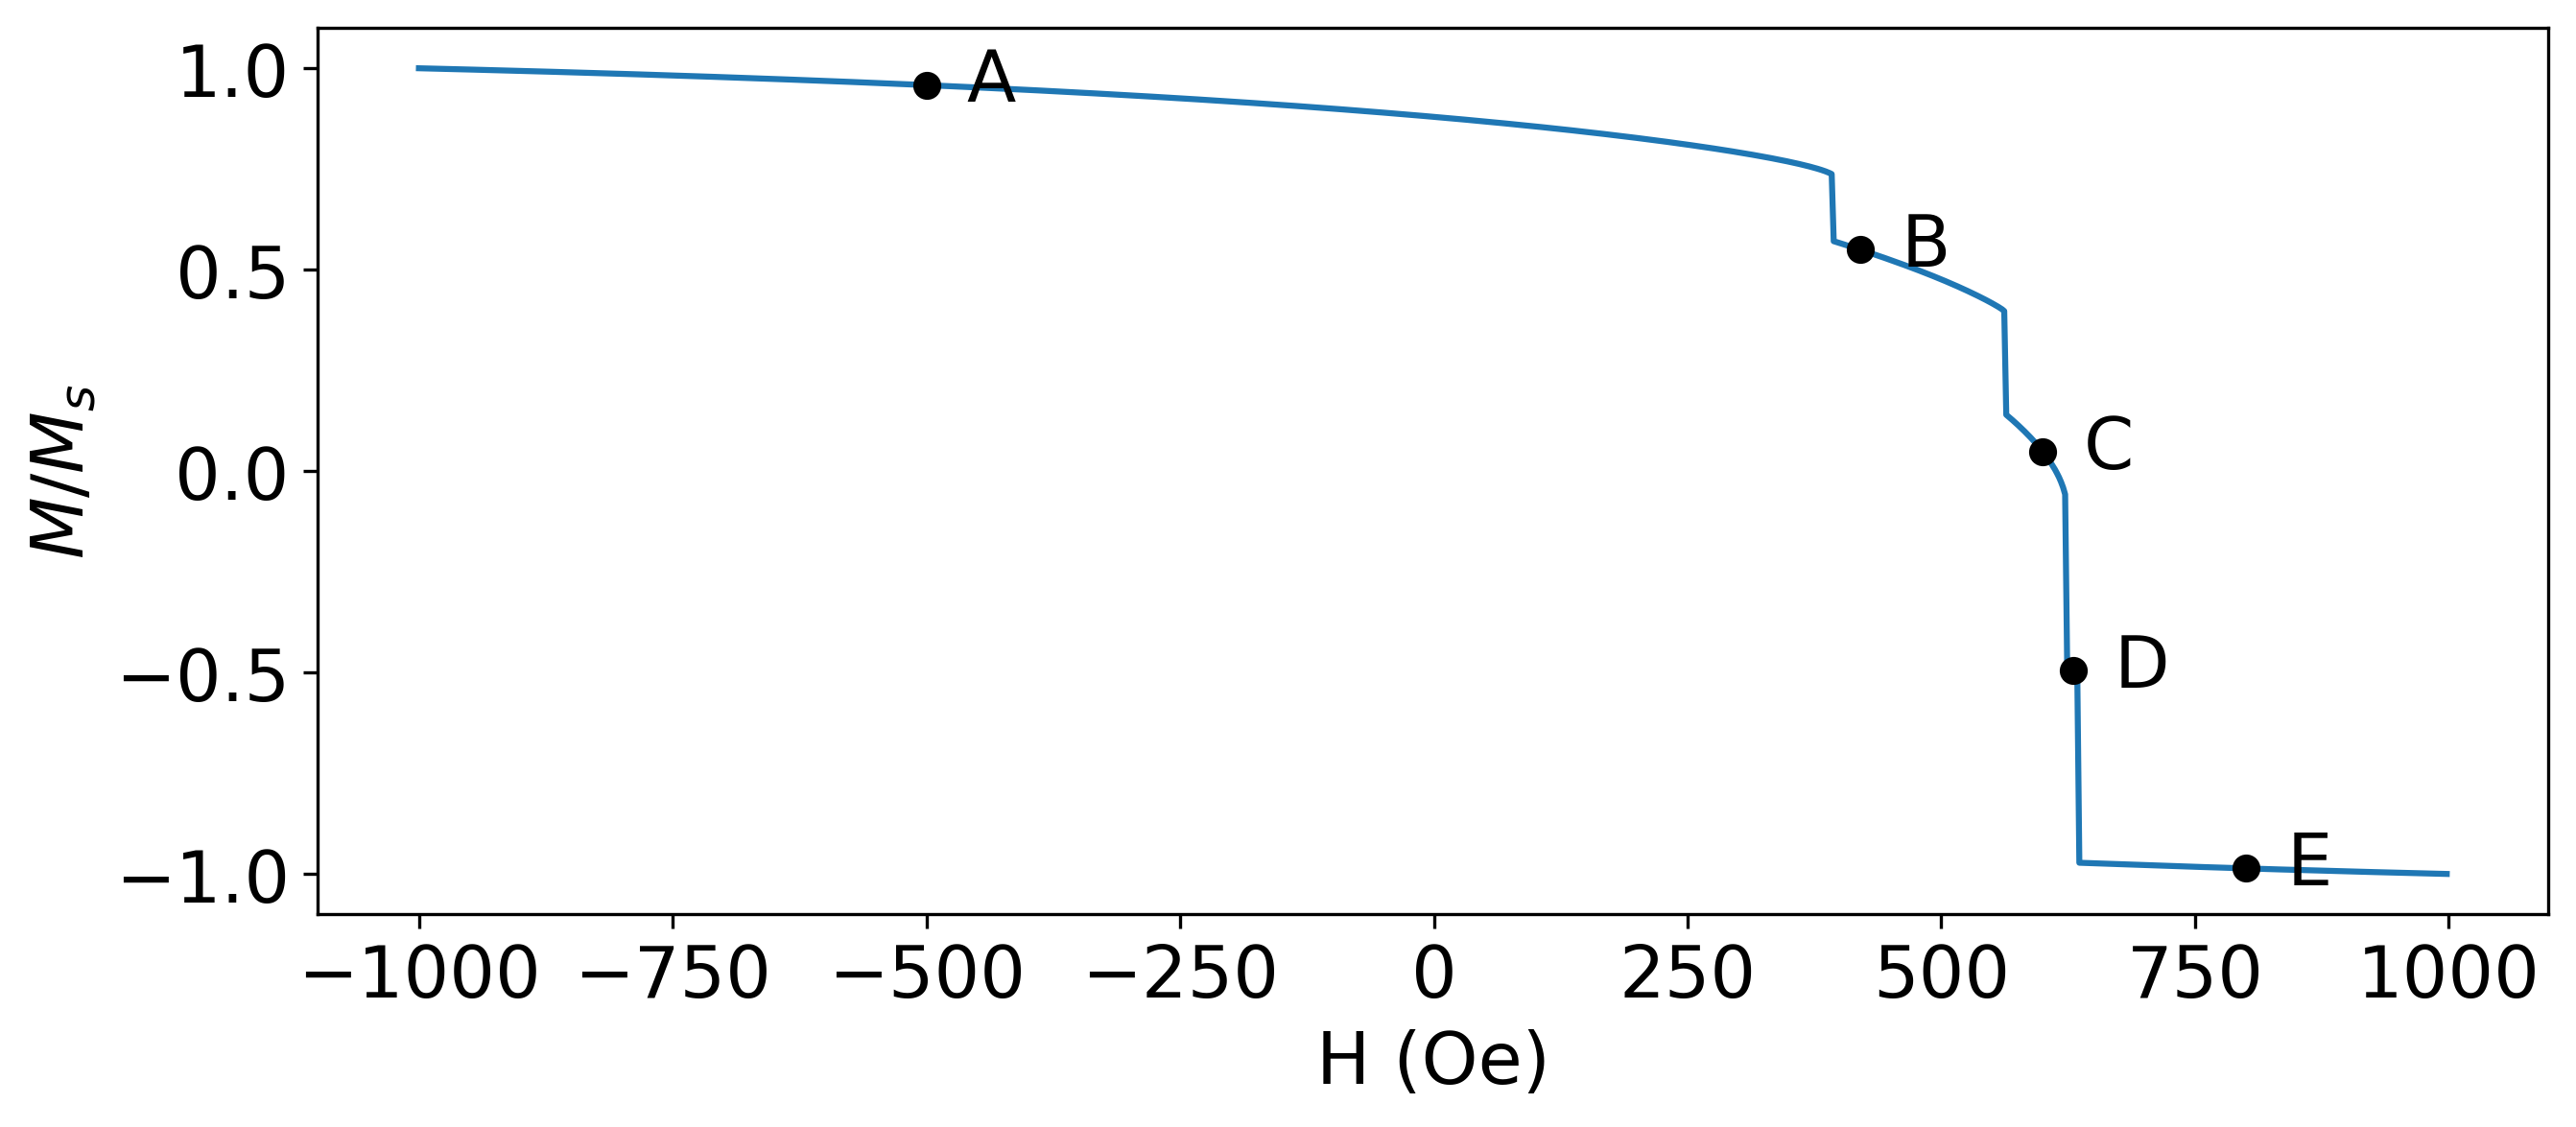

In [5]:
plt.rcParams.update({'font.size': 18})

run=getRuns(2.8e-7,0.3,1.8e-7)[0]

plt.figure(figsize=(10,4))
plt.plot(-run.H,run.m)


plt.xlabel("H (Oe)")
plt.ylabel("$M/M_s$")
#plt.title("Hysteresis Loop")


for i,name in zip([250,710,800,815,900],["A","B","C","D","E"]):
    plt.scatter(-run.H[i],run.m[i],color="k",zorder=10)
    plt.text(-run.H[i]+40,run.m[i]-0.04,name)